## Exercise:

* There are 922 e-mails divided equally between spam and non-spam(ham)
* The first line of every email contains the subject and the third line contains the body as shown:

![title](sample_email.png)

## Perform text analysis only on the body to detect spam mails

## Steps:
1. Read the body of all the emails. (Hint: Just google how to read multiple text files in python. Its very simple - all the text files can be read at once using a simple loop. But make sure while reading itself you read only the body (third line) and not the subject).
2. Once you read, the content of all the mails can be collected in a python list.
3. Create a pandas dataframe from that list and add the class label column [spam(1) or ham(0)]
4. The shape of the pandas dataframe must be (922 x 2) - 922 rows and 2 columns
5. Now perform the standard preprocessing steps on the contents of the mail (stopword removal, lower casing, etc.)
6. After that create vectors using Binary BOW, count BOW and TFIDF.
7. Use BernoulliNB with Binary BOW and MultinomialNB with Count BOW and TFIDF
8. Evaluate all the three methods using Accuracy, Confusion Matrix and F-1 Score.
9. Compare the results of the three methods

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sqlite3
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


import re
from nltk.corpus import stopwords
import nltk 

import glob
import errno

from sklearn.manifold import  TSNE
from sklearn.utils import shuffle

### reading multiple .txt file from Spam and Ham folder

In [3]:
def ret(loc):
    path =loc
    files = glob.glob(path)
    lst=[]
    for fname in files:
        try:
            with open(fname,'r') as f:
                lines = f.readlines()
                str = '' 
                for i in range(2,len(lines)):
                    str += lines[i].rstrip('\n') 
                    lst.append(str)
                f.close()
        except IOError as exc:
            if exc.errno != errno.EISDIR:
                raise
    return lst

In [4]:
spam=ret('/Users/abc/Desktop/machine learning/Models vectors/spam filter/Spam Dataset/Spam emails/*.txt')
ham=ret('/Users/abc/Desktop/machine learning/Models vectors/spam filter/Spam Dataset/Ham emails/*.txt')
print(len(spam))
print(len(ham))

481
481


#### Making pandas Dataframe

In [5]:
spam=pd.DataFrame(spam,columns=['mail'])
ham=pd.DataFrame(ham,columns=['mail'])
spam['type']=1
ham['type']=0
data=pd.concat([spam,ham],axis=0,ignore_index=True)
data

,mail,type
0,* * * * * * * * * * * * * * * display box cred...,1
1,"dear nlpeople , ' m sure ' ll agree auto insur...",1
2,"want best hunt camp vacation life , felton 's ...",1
3,57 million email addresses $ 99 want money ? p...,1
4,attention ! warn ! adult ! warn ! adult ! unde...,1
5,attention ! warn ! adult ! warn ! adult ! unde...,1
6,subject : re : are debt ? help . qualify finge...,1
7,= = = = = = = = = = = = = = = = = = = = = = = ...,1
8,57 million email addresses $ 99 want money ? p...,1
9,$ 3500 per week home computer ! put free softw...,1


#### Loading Data file

In [6]:
conn=sqlite3.connect('spam.sqlite')
c=conn.cursor()
spam.to_sql('Data',conn,if_exists='replace',index=False)
conn.close

<function Connection.close>

#### Checking Duplicated mails

In [9]:
data=data.drop_duplicates(subset=['mail'])
data.shape #25 duplicates mail 

(937, 2)

# Text Preprocessing 

#### Removal of stopwords

In [10]:
stop = set(stopwords.words('english'))

In [11]:
lst = ["wouldn't",'won', 'nor', 'not', 'against',"doesn't","don't"]
for word in lst:
    stop.remove(word)
print(stop)

{'am', 'itself', 'will', 'on', 'himself', "wasn't", 'that', 'after', 'being', 'do', 'their', 'but', 'don', 'when', 'll', 'wouldn', 'under', 'his', 'out', 'whom', 'as', "mightn't", 'ain', 'him', 'is', 'off', 'themselves', 'there', 'then', 're', "that'll", 'for', 'my', 'an', 'down', 'our', 'up', 'they', 'who', 'have', 'such', 'in', 'same', 'its', 'of', "you'll", 'aren', 'them', 'above', 'did', 'be', 'again', "shouldn't", 'into', "it's", 'he', 'hers', 'yourself', "haven't", 'other', 'below', 'so', "you're", "weren't", 'been', 'needn', 'all', "shan't", "aren't", 'by', 'no', 'ourselves', 'mustn', 'each', 'until', 'shan', "mustn't", "you've", 'were', 'which', 'very', 'd', 'about', 'are', 'hadn', 'she', 'a', 'both', 'where', 'the', 'own', 'her', 'few', 'from', 'couldn', 'has', 'and', 'to', 'now', 'or', 't', 'if', "needn't", "hasn't", 'doing', 'these', 'isn', 'myself', "couldn't", 'i', 'more', 'while', 'this', 'at', 'before', 'it', "won't", 'any', 'does', 'here', 'further', 'didn', 'having', "

In [12]:
sno = nltk.stem.SnowballStemmer('english')

#### Removal of html tags

In [22]:
def cleanhtml(sent):
    cleanr=re.compile('<.*?>')
    cleantext=re.sub(cleanr,' ',sent)
    return cleantext

#### Removal of puncuation tags

In [23]:
def cleanpunc(sent):
    cleaned=re.sub(r'[?|@|!|^|%|\'|"|#|$|:|*|+|-|=|\-|&|_]',r'',sent)
    cleaned=re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned

In [32]:
def preprocessing(series):
    
    i = 0
    str1=" "
    final_string = []    ## This list will contain cleaned sentences
    list_of_sent = []    ## This is a list of lists used as input to the W2V model at a later stage
    
    ## Creating below lists for future use
    all_positive_words=[] # store words from spam mail here
    all_negative_words=[] # store words from ham mail here
    

    for sent in series.values:
        filtered_sent=[]
        sent=cleanhtml(sent)
        sent=cleanpunc(sent)
        
        for clean_word in sent.split():
            if((clean_word.isalpha()) and (len(clean_word)>2)):
                if(clean_word.lower() not in stop):
                    s=(sno.stem(clean_word.lower()))
                    s=clean_word.lower()
                    filtered_sent.append(s)
                    if(data['type'].values)[i]==1:
                        all_positive_words.append(s)
                    if(data['type'].values)[i]==0:
                        all_negative_words.append(s)
                        
        list_of_sent.append(filtered_sent)
        str1=' '.join(filtered_sent)
        final_string.append(str1)
        i+=1
    return final_string,list_of_sent

In [33]:
final_string,list_of_sent=preprocessing(data['mail'])

In [35]:
data['cleaned_mail_stem']=final_string
print(data.shape)
data.head(10)

(937, 3)


,mail,type,cleaned_mail_stem
0,* * * * * * * * * * * * * * * display box cred...,1,display box credit application need place smal...
1,"dear nlpeople , ' m sure ' ll agree auto insur...",1,dear nlpeople sure agree auto insurance cost m...
2,"want best hunt camp vacation life , felton 's ...",1,want best hunt camp vacation life felton hunt ...
3,57 million email addresses $ 99 want money ? p...,1,million email addresses want money put touch m...
4,attention ! warn ! adult ! warn ! adult ! unde...,1,attention warn adult warn adult age interest s...
5,attention ! warn ! adult ! warn ! adult ! unde...,1,attention warn adult warn adult age interest s...
6,subject : re : are debt ? help . qualify finge...,1,subject debt help qualify fingertip long dista...
7,= = = = = = = = = = = = = = = = = = = = = = = ...,1,please read found father unite state america w...
8,57 million email addresses $ 99 want money ? p...,1,million email addresses want money put touch m...
9,$ 3500 per week home computer ! put free softw...,1,per week home computer put free software compu...


In [36]:
conn=sqlite3.connect('spam.sqlite')
c=conn.cursor()
spam.to_sql('Data',conn,if_exists='replace',index=False)
conn.close

<function Connection.close>

#### Making Pickle file with cleam_email

In [37]:
with open('list_of_sent_for_input_to_w2v.pkl','wb') as pickle_file:
    pickle.dump(list_of_sent,pickle_file)

# BOW

#### Shuffling all emails

In [38]:
data=shuffle(data,random_state=123)
data.head()

,mail,type,cleaned_mail_stem
791,- - - - - swiss linguistic society organize su...,0,swiss linguistic society organize summer schoo...
360,"hi , where wonder interest subscribe our opt-i...",1,wonder interest subscribe optin email list who...
582,forward follow post request robert rankin ( ra...,0,forward follow post request robert rankin rank...
611,* * * * * * celtic linguistics conference * * ...,0,celtic linguistics conference second post call...
284,"discover family history - rate "" cool site wee...",1,discover family history rate cool site week vi...


In [39]:
bow_vect=CountVectorizer()
bow=bow_vect.fit_transform(data['cleaned_mail_stem'].values)
x=bow[:,:].toarray()

In [49]:
x.shape

(937, 22900)

# tsne

In [46]:
tsne=TSNE(n_components=2,perplexity=30).fit_transform(x)
df=pd.DataFrame(tsne,columns=('dim1','dim2'))

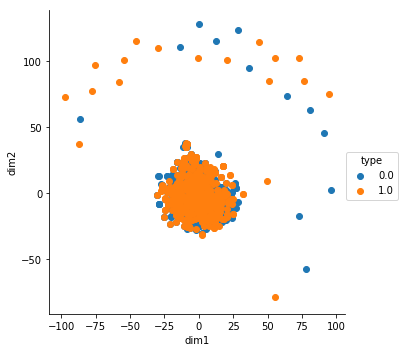

In [47]:
df=pd.concat([df,data['type'].iloc[:]],axis=1)
sns.FacetGrid(df,hue='type',size=5).map(plt.scatter,'dim1','dim2').add_legend()

# Binary - BOW for Bernoulli Naive - Bayes

In [52]:
bow_vect=CountVectorizer(binary=True)
bow=bow_vect.fit_transform(data['cleaned_mail_stem'].values)


In [53]:
x=bow  
y=data['type'].values
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,shuffle=False)

the optimal value of alpha is 0.030


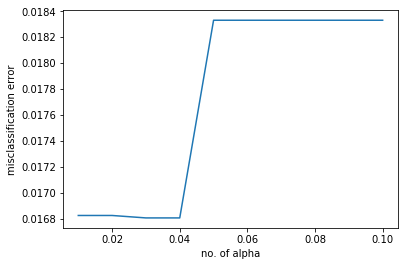

In [54]:
alpha=np.linspace(0.01,0.1,10)
cv_scores=[]

for a in alpha:
    clf=BernoulliNB(alpha=a)
    score=cross_val_score(clf,x_train,y_train,cv=8,scoring='accuracy')
    cv_scores.append(score.mean())
    
MSE=[1-x for x in cv_scores]

optimal_alpha=alpha[MSE.index(min(MSE))]
print('the optimal value of alpha is %0.3f' % optimal_alpha)
plt.plot(alpha,MSE)
plt.xlabel('no. of alpha')
plt.ylabel('misclassification error')
plt.show()

In [55]:
clf=BernoulliNB(alpha=optimal_alpha)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
acc=accuracy_score(y_test,y_pred,normalize=True)*float(100)
print(acc)
cof=confusion_matrix(y_test,y_pred).T
cof

99.6453900709


array([[145,   1],
       [  0, 136]], dtype=int64)

In [56]:
tp=int(cof[1:,1:])
fp=int(cof[1:,:1])
fn=int(cof[:1,1:])
pre=tp/(tp+fp)
rec=tp/(tp+fn)
fsco=(2*pre*rec)/(pre+rec)
print("precision is =",pre)
print("recall is =",rec)
print("fscore is =",fsco)

precision is = 1.0
recall is = 0.9927007299270073
fscore is = 0.9963369963369962


# multinomailNB - BOW

In [58]:
bow_vect=CountVectorizer()
bow=bow_vect.fit_transform(data['cleaned_mail_stem'].values)

In [59]:
x=bow  
y=data['type'].values
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,shuffle=False)

the optimal value of alpha is 0.043


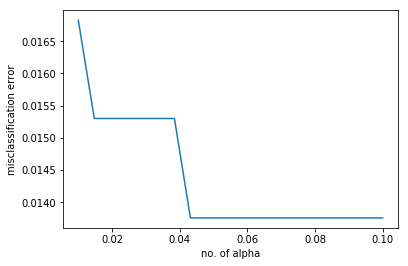

In [60]:
alpha=np.linspace(0.01,0.1,20)
cv_scores=[]

for a in alpha:
    clf=MultinomialNB(alpha=a)
    score=cross_val_score(clf,x_train,y_train,cv=8,scoring='accuracy')
    cv_scores.append(score.mean())
    
MSE=[1-x for x in cv_scores]

optimal_alpha=alpha[MSE.index(min(MSE))]
print('the optimal value of alpha is %0.3f' % optimal_alpha)
plt.plot(alpha,MSE)
plt.xlabel('no. of alpha')
plt.ylabel('misclassification error')
plt.show()

In [61]:
clf=MultinomialNB(alpha=optimal_alpha)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
acc=accuracy_score(y_test,y_pred,normalize=True)*float(100)
print(acc)
cof=confusion_matrix(y_test,y_pred).T
cof

98.9361702128


array([[145,   3],
       [  0, 134]], dtype=int64)

In [62]:
tp=int(cof[1:,1:])
fp=int(cof[1:,:1])
fn=int(cof[:1,1:])
pre=tp/(tp+fp)
rec=tp/(tp+fn)
fsco=(2*pre*rec)/(pre+rec)
print("precision is =",pre)
print("recall is =",rec)
print("fscore is =",fsco)

precision is = 1.0
recall is = 0.9781021897810219
fscore is = 0.988929889298893


# tdif tsne

In [50]:
tfidf_vec=TfidfVectorizer()
tfidf=tfidf_vec.fit_transform(data['cleaned_mail_stem'].values)
y=tfidf[:,:].toarray()

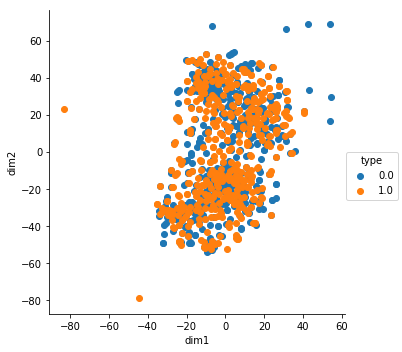

In [51]:
tsne=TSNE(n_components=2,perplexity=30).fit_transform(y)
df=pd.DataFrame(tsne,columns=('dim1','dim2'))
df=pd.concat([df,data['type'].iloc[:3500]],axis=1)
sns.FacetGrid(df,hue='type',size=5).map(plt.scatter,'dim1','dim2').add_legend()

# tdif -multinomailNB

In [63]:
tf_idf=TfidfVectorizer()
tfidf=tf_idf.fit_transform(data['cleaned_mail_stem'].values)
x=tfidf  
y=data['type'].values
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,shuffle=False)

the optimal value of alpha is 0.43


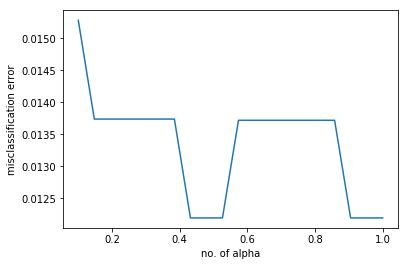

In [64]:
alpha=np.linspace(0.1,1,20)
cv_scores=[]

for a in alpha:
    clf=MultinomialNB(alpha=a)
    score=cross_val_score(clf,x_train,y_train,cv=8,scoring='accuracy')
    cv_scores.append(score.mean())
    
MSE=[1-x for x in cv_scores]

optimal_alpha=alpha[MSE.index(min(MSE))]
print('the optimal value of alpha is %0.2f' % optimal_alpha)
plt.plot(alpha,MSE)
plt.xlabel('no. of alpha')
plt.ylabel('misclassification error')
plt.show()

In [65]:
clf=MultinomialNB(alpha=optimal_alpha)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
acc=accuracy_score(y_test,y_pred,normalize=True)*float(100)
print(acc)
cof=confusion_matrix(y_test,y_pred).T
cof

98.5815602837


array([[142,   1],
       [  3, 136]], dtype=int64)

In [66]:
tp=int(cof[1:,1:])
fp=int(cof[1:,:1])
fn=int(cof[:1,1:])
pre=tp/(tp+fp)
rec=tp/(tp+fn)
fsco=(2*pre*rec)/(pre+rec)
print("precision is =",pre)
print("recall is =",rec)
print("fscore is =",fsco)

precision is = 0.9784172661870504
recall is = 0.9927007299270073
fscore is = 0.9855072463768116


# CONCLUSION
* Amongst all model Binary BOW has excellent confusion matrix with correct prediction and also high acc,recall,fscore
* we have tdif is showing more overlap but still its showing goood result